# Synthetic Data

Here we generate and characterise synthetic data with periodic reporting biases.

## Data Generation

This section illustrates the methods used to generate synthetic data with known weekly reporting biases.

In [70]:
# Imports

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '12'

from datetime import datetime

from renewal_model import RenewalModel
from biased_reporter import Reporter

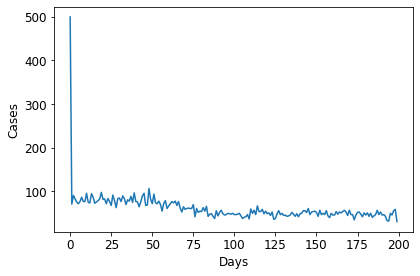

In [71]:
# Simulate Renewal Model
time_steps = 200
N_0 = 500

model = RenewalModel(R0=0.99)
model.simulate(T=time_steps, N_0=N_0)
model.plot()

In [72]:
# Report unbiased and biased data

rep = Reporter(model.case_data)
truth_df = rep.unbiased_report()
bias_df = rep.fixed_bias_report(bias = [0.5, 1.4, 1.2, 1.1, 1.1, 1.1, 0.6],
                                multinomial_dist=True)

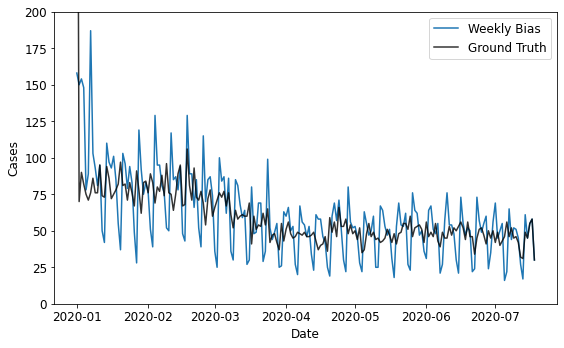

In [73]:
# Plot bias in data

fig, axs = plt.subplots(1, figsize=(8,5))

bias_df.plot(x='Date', y='Confirmed', ax=axs, color='tab:blue', label = 'Weekly Bias')
truth_df.plot(x='Date', y='Confirmed', ax=axs, color='black', label = 'Ground Truth', alpha=0.8)
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("Cases")
plt.legend(); plt.ylim(0, 200); plt.tight_layout()
# plt.savefig("../../images/synthetic_examples/"
#             + f"biased_output_T_{time_steps}_N0_{N_0}.png")
plt.show()

Our ultimate aim is to be able to reconstruct the black _'Ground Truth'_ data from the blue _'Weekly Bias'_ data. Naturally, we cannot do this perfectly, due to the stochastic nature of both the original data and the weekly bias.

However, the overall trends of the data may be recovered (in this case case numbers decrease slowly as $R_{0} > 0$), with the underlying $R_{0}$ value inferred?

## Bias Characterisation

We may consider the nature of the weekly reporting bias in a similar way to before.

In [74]:
# Function duplication - temporary

def rel_reporting_calc(df, column_list):
    """Adds columns to dataframe giving weekday information,
    as well as the relative reporting factor."""
    df['Day_Index'] = df['Date'].apply(lambda x: x.weekday())
    df['Weekday'] = df['Date'].apply(lambda x: x.day_name())
    for column in column_list:
        mean = df[column].rolling(7).mean()
        df['Dif_' + column] = df[column] / mean
    return df

bias_df['Date'] = bias_df['Date'].apply(lambda t: datetime.combine(t, datetime.min.time()))
df = rel_reporting_calc(bias_df, ['Confirmed', 'Ground Truth'])

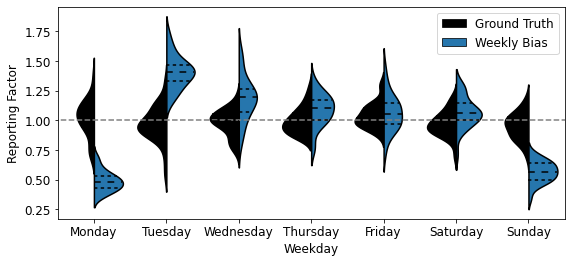

In [78]:
# Function duplication - ditto to above

def rel_reporting_violin(daily_df, value_cols, ax, cutoff, colors, labels):
    for column in value_cols:
        daily_df = rel_reporting_calc(daily_df, [column])

    id_col = list(daily_df.columns.values)
    for i, value in enumerate(value_cols):
        value_cols[i] = 'Dif_' + value
        id_col.remove('Dif_' + value)
    violin_df = pd.melt(daily_df, id_vars = id_col, value_vars=value_cols, var_name='Type')
    ax.hlines(y=1, xmin=-1, xmax=7, linestyles="dashed", color="gray")

    #N.B exclude zero values from discrete nature of data - distorts violin
    sns.violinplot(data=violin_df, y=violin_df[(violin_df['value']<cutoff) & (violin_df['value']>0)]['value'],
                   ax=ax, x='Weekday', hue='Type', palette=colors, saturation=0.9, split=True, inner='quartile',# cut=0,
                   order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    ax.set_title(''); ax.set_xlim(-0.5,6.5)
    ax.legend(handles=ax.legend_.legendHandles, labels=labels)

fig, axs = plt.subplots(1, figsize=(8,4))
rel_reporting_violin(df.copy(), ['Ground Truth', 'Confirmed'],  ax=axs, cutoff=2,
                     colors=['black', 'tab:blue'], labels=["Ground Truth", "Weekly Bias"])  

fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel('Weekday'); plt.ylabel("Reporting Factor")
plt.suptitle(''); plt.tight_layout()
# plt.savefig("../../images/synthetic_examples/"
#             + f"biased_violin_T_{time_steps}_N0_{N_0}.png")